## Pre Procesamiento del Dataset (Alineacion y extracción de Keypoints)

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

#Funcion para calcular angulos
def calculate_angle(a, b, c):
    """Calcula el ángulo entre tres puntos (en grados)."""
    a = np.array(a) # Primer punto (ej. hombro)
    b = np.array(b) # Punto medio (ej. codo)
    c = np.array(c) # Punto final (ej. muñeca)
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# --- Procesamiento de Videos ---
base_path = 'exercices'
exercises_to_process = ["test_squat", "test_push up", "test_plank"]

all_landmarks_data = []

print("Iniciando procesamiento de videos...")

# Iterar sobre cada ejercicio seleccionado
for exercise_name in exercises_to_process:
    exercise_path = os.path.join(base_path, exercise_name)
    
    if not os.path.isdir(exercise_path):
        print(f"Advertencia: La carpeta para '{exercise_name}' no fue encontrada en '{base_path}'. Saltando.")
        continue
    print(f"Procesando ejercicio: {exercise_name}")
    

    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error al abrir el video: {video_path}")
            continue
            
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            #Conversion imagen a RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            
            # Extraer landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                
                # Coordenadas de los puntos clave
                shoulder_l = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow_l = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist_l = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                hip_l = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
                knee_l = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                ankle_l = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
                
                shoulder_r = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]

                # Calcular ángulos
                angle_elbow_l = calculate_angle(shoulder_l, elbow_l, wrist_l)
                angle_shoulder_l = calculate_angle(hip_l, shoulder_l, elbow_l)
                angle_hip_l = calculate_angle(shoulder_l, hip_l, knee_l)
                angle_knee_l = calculate_angle(hip_l, knee_l, ankle_l)
                
                # Guardar los datos
                all_landmarks_data.append({
                    "exercise": exercise_name,
                    "angle_elbow_l": angle_elbow_l,
                    "angle_shoulder_l": angle_shoulder_l,
                    "angle_hip_l": angle_hip_l,
                    "angle_knee_l": angle_knee_l,
                })
                
            except:
                pass
                
        cap.release()

print("Procesamiento finalizado.")

# Convertir la lista de datos a un DataFrame de Pandas
df = pd.DataFrame(all_landmarks_data)

output_path = 'fitness_pose_data.csv'
df.to_csv(output_path, index=False)

print(f"Datos guardados exitosamente en '{output_path}'")
print("Primeras filas del dataset:")
print(df.head())

Iniciando procesamiento de videos...
Procesando ejercicio: test_squat
Procesando ejercicio: test_push up
Procesando ejercicio: test_plank
Procesamiento finalizado.
Datos guardados exitosamente en 'fitness_pose_data.csv'
Primeras filas del dataset:
     exercise  angle_elbow_l  angle_shoulder_l  angle_hip_l  angle_knee_l
0  test_squat      39.418914          7.513684   175.154000    179.653261
1  test_squat      39.447593          7.147218   175.540319    179.383541
2  test_squat       4.481374         29.868239   162.565000    158.359965
3  test_squat     178.504655        174.217287   174.536982    169.333770
4  test_squat     113.673083        107.736658   177.554059    176.610894


## Entrenar y Evaluar tu Modelo (MVP)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [5]:
df = pd.read_csv('fitness_pose_data.csv')
df['exercise'] = df['exercise'].str.replace('test_', '', regex=False)

X = df.drop('exercise', axis=1) # Las características (features)
y = df['exercise']             # Las etiquetas (target)

#Division de datos de prueba y testeo
# stratify=y es importante para mantener la proporción de ejercicios en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Usar modelo de random forest generico
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
#Evaluar modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo: {accuracy * 100:.2f}%\n")

# 6. Mostrar un reporte más detallado
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo: 98.60%

Reporte de Clasificación:
              precision    recall  f1-score   support

       plank       0.99      1.00      0.99      2918
     push up       0.95      0.96      0.96       435
       squat       0.98      0.91      0.94       301

    accuracy                           0.99      3654
   macro avg       0.98      0.95      0.96      3654
weighted avg       0.99      0.99      0.99      3654



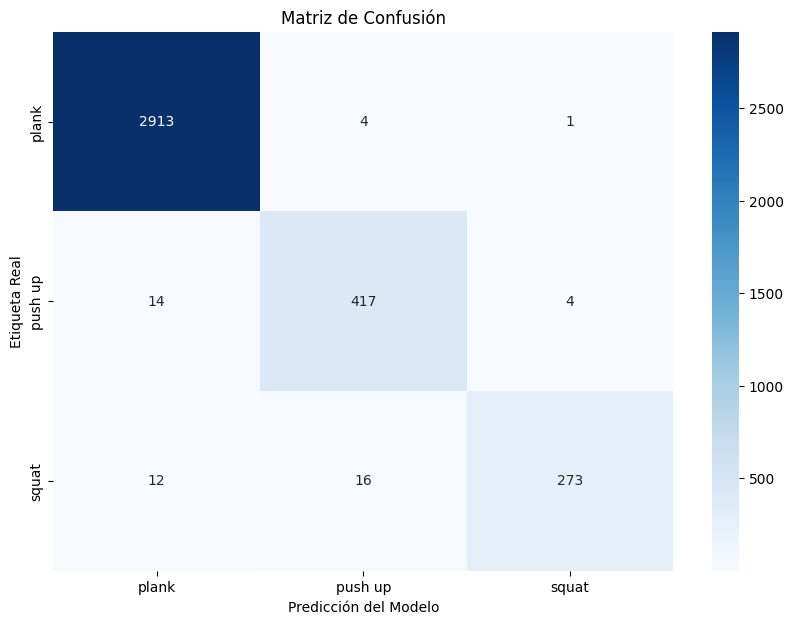

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

In [8]:
model_filename = 'fitness_exercise_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Modelo guardado exitosamente como '{model_filename}'")

Modelo guardado exitosamente como 'fitness_exercise_model.pkl'


## Ejecución del modelo en Tiempo Real 

In [15]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Reutilizar la función y la configuración de MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle

#Cargar modelo (mvp)
model_filename = 'fitness_exercise_model.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

print("Modelo cargado exitosamente.")

# ELEGIR CAMARA DEL USUARIO
cap = cv2.VideoCapture(0) # 0 para la cámara web principal

current_exercise = "" #Variable dinamica (ejercicio detectado)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    #Conversión de imagen a rgb
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Detección de pose
    results = pose.process(image)

    # Convertir la imagen de nuevo a BGR para dibujarla con OpenCV
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Extraer landmarks y hacer la predicción
    try:
        landmarks = results.pose_landmarks.landmark

        #Puntos clave
        required_landmarks = [
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
            landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
            landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
        ]
        
        # Comprueba si todos los puntos clave requeridos son suficientemente visibles
        if all(landmark.visibility > 0.6 for landmark in required_landmarks):
            
            shoulder_l = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow_l = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist_l = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            hip_l = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            knee_l = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            ankle_l = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            
            angle_elbow_l = calculate_angle(shoulder_l, elbow_l, wrist_l)
            angle_shoulder_l = calculate_angle(hip_l, shoulder_l, elbow_l)
            angle_hip_l = calculate_angle(shoulder_l, hip_l, knee_l)
            angle_knee_l = calculate_angle(hip_l, knee_l, ankle_l)
            
            # Dataframe de la predicción
            features = pd.DataFrame([[angle_elbow_l, angle_shoulder_l, angle_hip_l, angle_knee_l]], 
                                    columns=['angle_elbow_l', 'angle_shoulder_l', 'angle_hip_l', 'angle_knee_l'])
            
            # Predicción
            prediction = model.predict(features)
            current_exercise = prediction[0]
        
        # Si no cumple el umbral botar vacio
        else:
            current_exercise = "" # O "No se detecta ejercicio"

    except Exception as e:

        current_exercise = ""
        pass

    #HUD DEL USUARIO (mvp)
    # Dibujar un rectángulo para el texto
    cv2.rectangle(image, (0,0), (400, 60), (245, 117, 16), -1)

    # Mostrar el texto del ejercicio predicho
    cv2.putText(image, 'EJERCICIO', (15,20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
    cv2.putText(image, current_exercise, (10,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    # Dibujar los landmarks de la pose en el frame
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

    cv2.imshow('MVP BASICO', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Modelo cargado exitosamente.


KeyboardInterrupt: 